In [1]:
import matplotlib.patches as mpatche
import geopandas as gpd
import rasterio
from rasterio.plot import show
from rasterio.warp import calculate_default_transform, reproject, Resampling
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
# Import necessary libraries
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from rasterio.plot import show
from rasterio.warp import calculate_default_transform, reproject, Resampling
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from sklearn.model_selection import GridSearchCV
from sklearn.tree import export_text, plot_tree

In [2]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from rasterio.plot import show
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, cohen_kappa_score
from sklearn.tree import export_text, plot_tree
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import seaborn as sns

def read_image(file_path):
    image = rasterio.open(file_path)
    return image

def prepare_data(training_data_path, layer):
    training_data = gpd.read_file(training_data_path, layer=layer)
    return training_data

def read_training_data(training_data, image):
    X = []  # Feature vector
    y = []  # Class labels

    for index, row in training_data.iterrows():
        # Extract pixel values within the boundaries of each training area
        geom = row['geometry']
        out_image, out_transform = mask(image, [geom], crop=True)
        out_image = np.moveaxis(out_image, 0, -1)  # Move axis to match sklearn format
        flat_pixels = out_image.reshape(-1, out_image.shape[-1])
        for pixel in flat_pixels:
            X.append(pixel)
            y.append(row['class'])
    return X, y

def calculate_metrics(y_test, y_pred, conf_matrix):
    # Producer's Accuracy (PA)
    PA = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
    PA_dict = {i: PA[i] for i in range(len(PA))}

    # User's Accuracy (UA)
    UA = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)
    UA_dict = {i: UA[i] for i in range(len(UA))}

    # Kappa Coefficient (κ)
    kappa = cohen_kappa_score(y_test, y_pred)

    return PA_dict, UA_dict, kappa

def train_model(X, y, file_path):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)  # test_size = training/test ratio
    classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    classifier.fit(X_train, y_train)
    
    # Predict on training set
    y_train_pred = classifier.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    print(f'Training accuracy of {file_path} is: ', train_accuracy)
    
    # Predict on test set
    y_test_pred = classifier.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print(f'Test accuracy of {file_path} is: ', test_accuracy)

    conf_matrix = confusion_matrix(y_test, y_test_pred)
    
    # Calculate additional metrics
    PA_dict, UA_dict, kappa = calculate_metrics(y_test, y_test_pred, conf_matrix)
    print(f"Producer's Accuracy (PA): {PA_dict}")
    print(f"User's Accuracy (UA): {UA_dict}")
    print(f"Kappa Coefficient (κ): {kappa:.4f}")

    # Plot confusion matrix with labels
    if file_path == 'virtual raster prefire_mask.tif':
        custom_labels = ['not forest', 'forest']  # Adjust labels as needed
    elif file_path == 'post_fire.tif':
        custom_labels = ['not burned', 'burned area']  # Adjust labels as needed
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=custom_labels,
                yticklabels=custom_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    return classifier

def classify_image(model, image):
    image_data = image.read().transpose(1, 2, 0)  # Move bands to the last axis
    rows, cols, bands = image_data.shape
    image_data_reshaped = image_data.reshape(rows * cols, bands)
    predicted_classes = model.predict(image_data_reshaped)
    predicted_classes_reshaped = predicted_classes.reshape(rows, cols)
    return predicted_classes_reshaped

def visualize_classified_image(predicted_classes_reshaped, file_path):
    if file_path == 'post_fire.tif':
        colors = ['white', 'black']
        class_bins = [1, 2]  # Adjust bins as needed
        class_labels = ['not burned', 'burned area']  # Adjust labels as needed
    elif file_path == 'virtual raster prefire_mask.tif':
        colors = ['white', 'black']
        class_bins = [1, 2]  # Adjust bins as needed
        class_labels = ['not forest', 'forest']  # Adjust labels as needed
    
    cmap = ListedColormap(colors)
    
    plt.figure(figsize=(10, 10))
    show(predicted_classes_reshaped, cmap=cmap)
    
    # Create custom legend
    patches = [mpatches.Patch(color=colors[i], label=class_labels[i]) for i in range(len(class_labels))]
    plt.legend(handles=patches, bbox_to_anchor=(1, 1), loc='upper left')
    plt.show()

def save_classified_image(predicted_classes_reshaped, output_path):
    with rasterio.open(output_path, 'w', **image.meta) as dst:
        dst.write(predicted_classes_reshaped.astype(rasterio.uint8), 1)

def visualize_tree_rules(classifier, tree_index=0):
    tree = classifier.estimators_[tree_index]
    tree_rules = export_text(tree)
    print(tree_rules)
    
    plt.figure(figsize=(20,10))
    plot_tree(tree, filled=True, rounded=True, feature_names=[f'Feature {i}' for i in range(len(classifier.feature_importances_))])
    plt.show()



Training accuracy of post_fire.tif is:  0.9605666156202144
Test accuracy of post_fire.tif is:  0.9651785714285714
Producer's Accuracy (PA): {0: 1.0, 1: 0.8381742738589212}
User's Accuracy (UA): {0: 0.9575163398692811, 1: 1.0}
Kappa Coefficient (κ): 0.8905


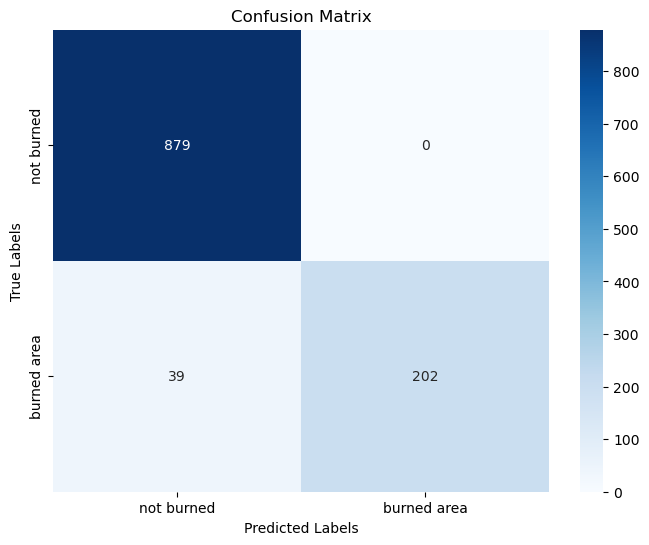

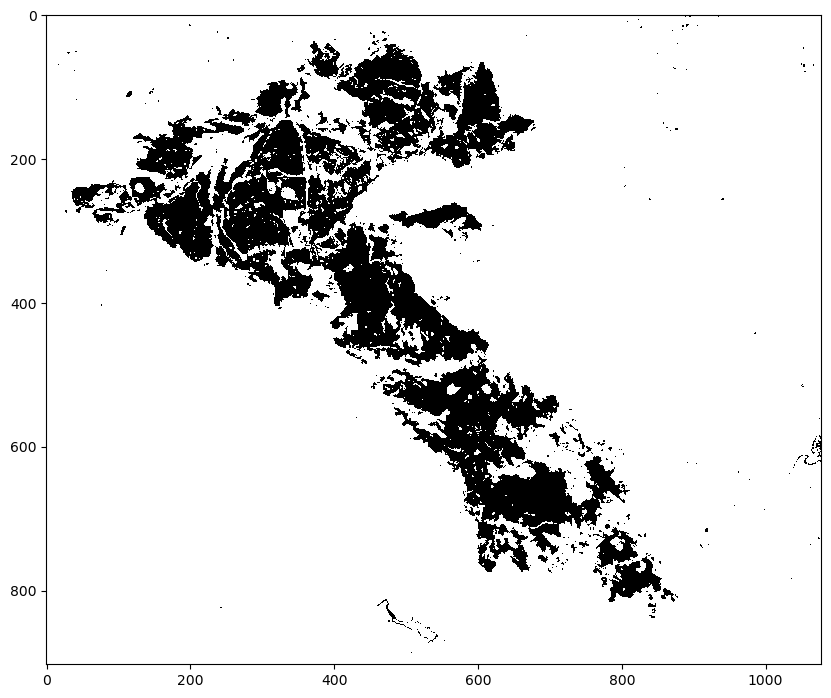

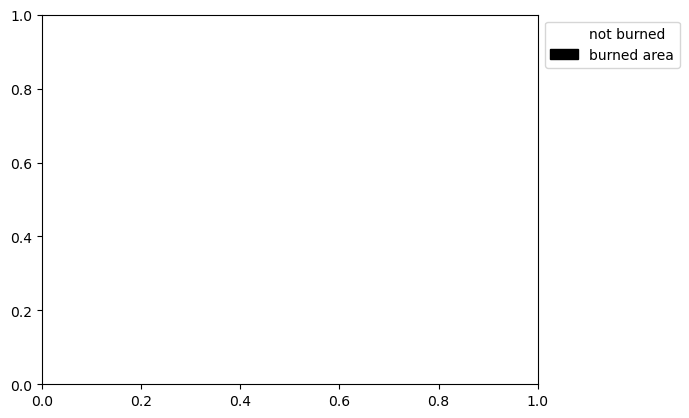

In [3]:
# Usage example
file_path = 'post_fire.tif'
image = read_image(file_path)
training_data = prepare_data('poly_postfire.gpkg' , 'poly_postfire')
X , y = read_training_data(training_data , image )
model = train_model(X, y,file_path)
predicted_classes_reshaped = classify_image(model, image)
visualize_classified_image(predicted_classes_reshaped ,file_path )
# visualize_tree_rules(model, tree_index=0)
save_classified_image(predicted_classes_reshaped, 'virtual raster postfire_clip_classified_image.tif')

Training accuracy of virtual raster prefire_mask.tif is:  0.9626984126984127
Test accuracy of virtual raster prefire_mask.tif is:  0.944932901434521
Producer's Accuracy (PA): {0: 0.9918256130790191, 1: 0.8962264150943396}
User's Accuracy (UA): {0: 0.908485856905158, 1: 0.9906152241918665}
Kappa Coefficient (κ): 0.8896


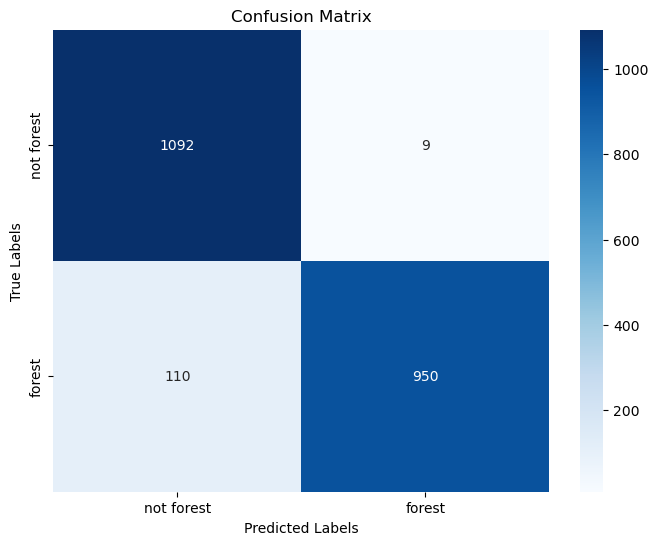

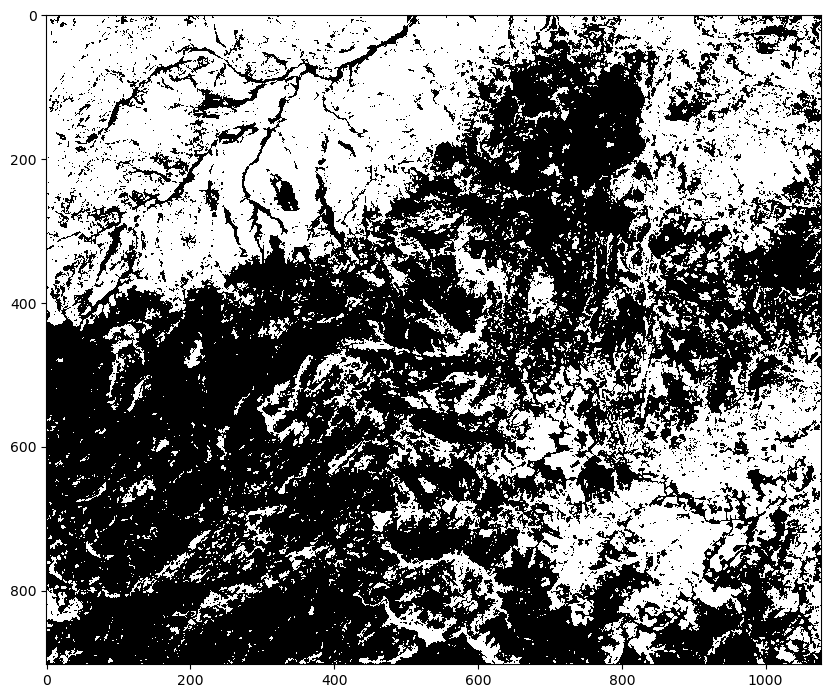

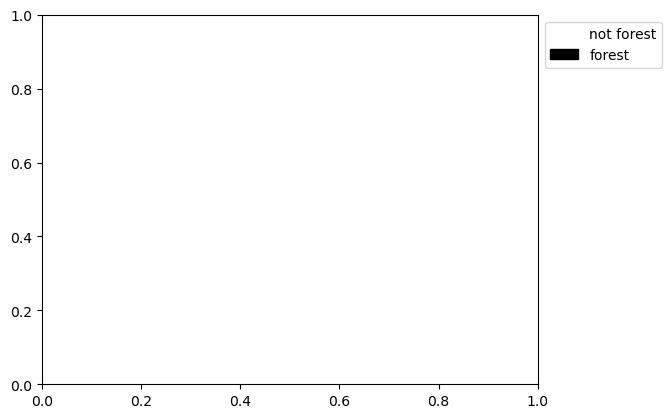

In [4]:
# Usage example
file_path = 'virtual raster prefire_mask.tif'
image = read_image(file_path)
training_data = prepare_data('poly.gpkg' ,'poly')
X , y = read_training_data(training_data , image )
model = train_model(X, y,file_path)
predicted_classes_reshaped = classify_image(model, image)
visualize_classified_image(predicted_classes_reshaped, file_path)
# visualize_tree_rules(model, tree_index=0)
save_classified_image(predicted_classes_reshaped, 'virtual raster prefire_clip_classified_image.tif')

In [5]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from rasterio.plot import show
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import seaborn as sns

# Define the necessary functions

def read_image(file_path):
    return rasterio.open(file_path)

def detect_changes(prefire_image, postfire_image):
    prefire_data = prefire_image.read(1)
    postfire_data = postfire_image.read(1)

    # Create a new array to store changes
    changes = np.zeros_like(prefire_data)

    # Iterate over each pixel to identify changes
    for i in range(prefire_data.shape[0]):
        for j in range(prefire_data.shape[1]):
            if prefire_data[i, j] == 1:  # Not forest in prefire
                if postfire_data[i, j] == 1:
                    changes[i, j] = 1  # Not forest to not burned (no change)
                elif postfire_data[i, j] == 2:
                    changes[i, j] = 2  # Not forest to burned
            elif prefire_data[i, j] == 2:  # Forest in prefire
                if postfire_data[i, j] == 1:
                    changes[i, j] = 3  # Forest to not burned
                elif postfire_data[i, j] == 2:
                    changes[i, j] = 4  # Forest to burned 

    return changes

def visualize_changes(changes):
    colors = [
        'white',  # Not forest to not burned (no change)
        'red',  # Not forest to burned
        'green',  # Forest to not burned
        'blue',  # Forest to burned
    ]
    class_labels = [
        'Not forest to not burned ', 'Not forest to burned', 'Forest to not burned',
        'Forest to burned'
    ]
    cmap = ListedColormap(colors)

    plt.figure(figsize=(10, 10))
    show(changes, cmap=cmap)

    # Create custom legend
    patches = [mpatches.Patch(color=colors[i], label=class_labels[i]) for i in range(len(class_labels))]
    plt.legend(handles=patches, bbox_to_anchor=(1, 1), loc='upper left')
    plt.show()

def calculate_area_by_class(image_data, image_meta, class_value):
    # Determine the pixel area in square meters
    pixel_area = abs(image_meta['transform'][0] * image_meta['transform'][4])

    # Count the number of pixels of the given class
    class_pixel_count = np.sum(image_data == class_value)

    # Calculate the total area in square meters
    class_area_sqm = class_pixel_count * pixel_area

    # Convert the area to hectares
    class_area_ha = class_area_sqm / 10000

    return class_area_sqm, class_area_ha

def calculate_forest_area_change(prefire_image, postfire_image):
    prefire_data = prefire_image.read(1)
    postfire_data = postfire_image.read(1)

    # Calculate forest area in prefire image (class value = 2)
    prefire_forest_sqm, prefire_forest_ha = calculate_area_by_class(prefire_data, prefire_image.meta, 2)

    # Calculate burned area in postfire image (class value = 2)
    postfire_burned_sqm, postfire_burned_ha = calculate_area_by_class(postfire_data, postfire_image.meta, 2)

    # # Calculate the difference
    # forest_area_change_sqm = postfire_forest_sqm - postfire_burned_sqm
    # forest_area_change_ha = forest_area_change_sqm / 10000

    return prefire_forest_sqm, prefire_forest_ha, postfire_burned_sqm, postfire_burned_ha

def calculate_burned_area(changes, image_meta):
    # Determine the pixel area in square meters
    # pixel_area = abs(image_meta['transform'][0] * image_meta['transform'][4])
    pixel_area = 400
    # Count the number of burned pixels
    burned_pixel_count = np.sum((changes == 2) | (changes == 4))
    # burned_pixel_count = np.sum(changes == 4)
    # Calculate the total burned area in square meters
    burned_area_sqm = burned_pixel_count * pixel_area

    # Convert the burned area to hectares
    burned_area_ha = burned_area_sqm / 10000

    return burned_area_sqm, burned_area_ha

def calculate_forest_to_burned_area(prefire_image, postfire_image):
    prefire_data = prefire_image.read(1)
    postfire_data = postfire_image.read(1)

    # Identify pixels that were forest (class 2) in prefire and burned (class 2) in postfire
    forest_to_burned_pixels = np.logical_and(prefire_data == 2, postfire_data == 2)

    # Determine the pixel area in square meters
    #pixel_area = abs(prefire_image.meta['transform'][0] * prefire_image.meta['transform'][4])
    pixel_area = 400
    # Count the number of forest-to-burned pixels
    forest_to_burned_pixel_count = np.sum(forest_to_burned_pixels)

    # Calculate the total forest-to-burned area in square meters
    forest_to_burned_area_sqm = forest_to_burned_pixel_count * pixel_area

    # Convert the forest-to-burned area to hectares
    forest_to_burned_area_ha = forest_to_burned_area_sqm / 10000

    return forest_to_burned_area_sqm, forest_to_burned_area_ha

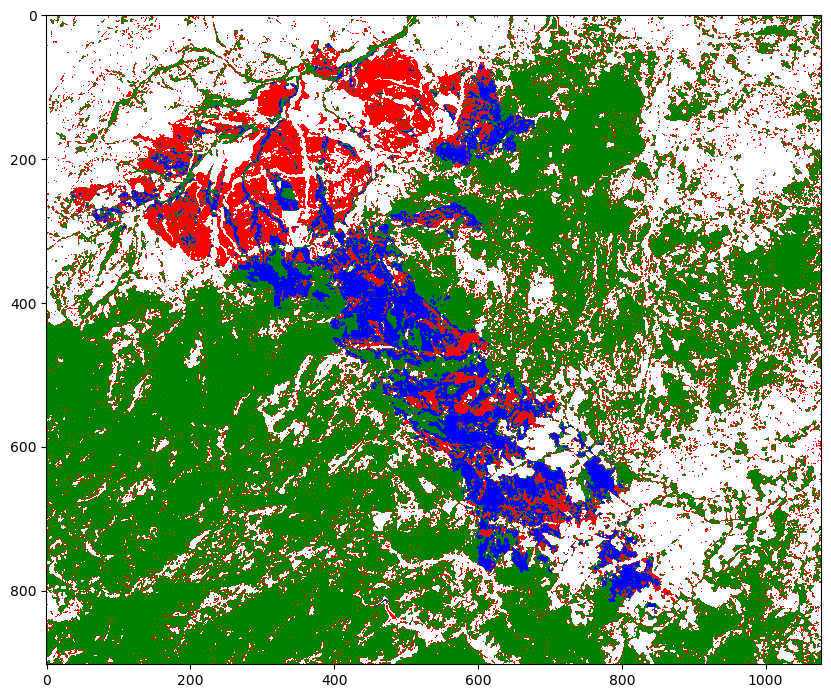

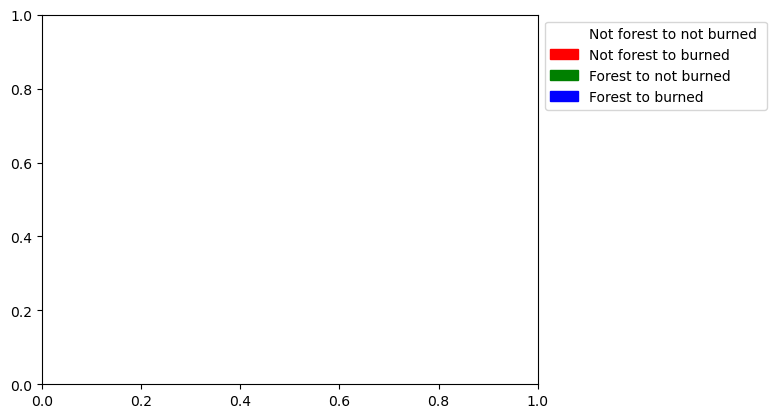

Total burned area: 52714000.00 square meters (5271.40 hectares)
Prefire forest area: 220049200.00 square meters (22004.92 hectares)
Postfire burned area: 52714000.00 square meters (5271.40 hectares)
Forest to burned area: 23347600.00 square meters (2334.76 hectares)


In [6]:
# Usage example
prefire_file_path = 'virtual raster prefire_clip_classified_image.tif'
postfire_file_path = 'virtual raster postfire_clip_classified_image.tif'

prefire_image = read_image(prefire_file_path)
postfire_image = read_image(postfire_file_path)

# Detect changes
changes = detect_changes(prefire_image, postfire_image)

# Visualize changes
visualize_changes(changes)

# Calculate and print burned area
burned_area_sqm, burned_area_ha = calculate_burned_area(changes, postfire_image.meta)
print(f'Total burned area: {burned_area_sqm:.2f} square meters ({burned_area_ha:.2f} hectares)')

# Calculate and print forest area change
prefire_forest_sqm, prefire_forest_ha, postfire_burned_sqm, postfire_burned_ha = calculate_forest_area_change(prefire_image, postfire_image)
print(f'Prefire forest area: {prefire_forest_sqm:.2f} square meters ({prefire_forest_ha:.2f} hectares)')
print(f'Postfire burned area: {postfire_burned_sqm:.2f} square meters ({postfire_burned_ha:.2f} hectares)')
# print(f'Forest area change: {forest_area_change_sqm:.2f} square meters ({forest_area_change_ha:.2f} hectares)')

# if forest_area_change_ha > 0:
#     print(f'The forest area increased by {forest_area_change_ha:.2f} hectares.')
# else:
#     print(f'The forest area decreased by {abs(forest_area_change_ha):.2f} hectares.')

# Calculate and print forest to burned area
forest_to_burned_sqm, forest_to_burned_ha = calculate_forest_to_burned_area(prefire_image, postfire_image)
print(f'Forest to burned area: {forest_to_burned_sqm:.2f} square meters ({forest_to_burned_ha:.2f} hectares)')


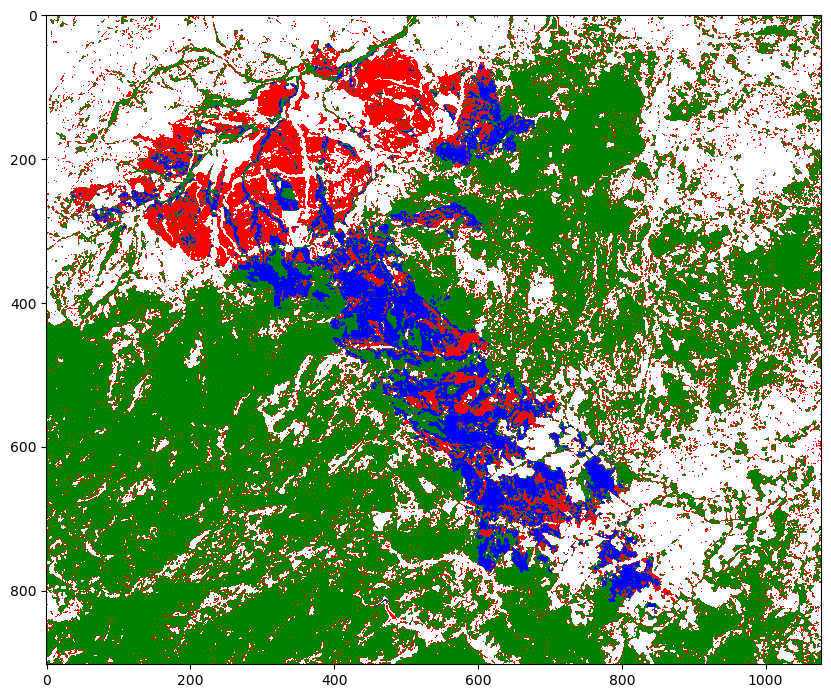

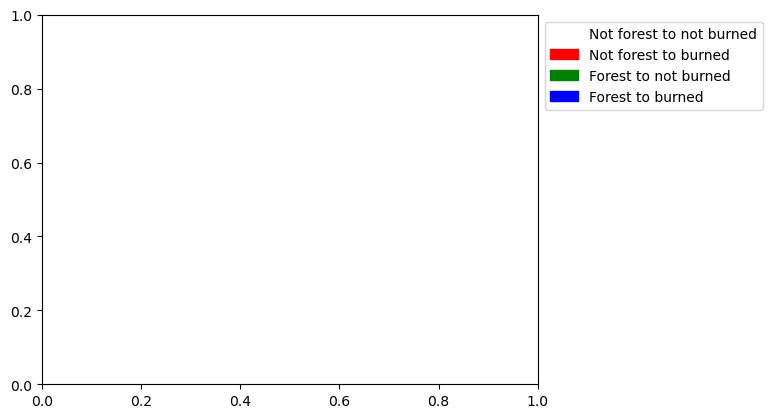

Forest labeled in prefire and identified as burned in postfire: 23347600.00 square meters (2334.76 hectares)
Not forest to burned area: 29366400.00 square meters (2936.64 hectares)


In [7]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from rasterio.plot import show
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import seaborn as sns

# Define the necessary functions

def read_image(file_path):
    return rasterio.open(file_path)

def detect_changes(prefire_image, postfire_image):
    prefire_data = prefire_image.read(1)
    postfire_data = postfire_image.read(1)

    # Create a new array to store changes
    changes = np.zeros_like(prefire_data)

    # Iterate over each pixel to identify changes
    for i in range(prefire_data.shape[0]):
        for j in range(prefire_data.shape[1]):
            if prefire_data[i, j] == 1:  # Not forest in prefire
                if postfire_data[i, j] == 1:
                    changes[i, j] = 1  # Not forest to not burned (no change)
                elif postfire_data[i, j] == 2:
                    changes[i, j] = 2  # Not forest to burned
            elif prefire_data[i, j] == 2:  # Forest in prefire
                if postfire_data[i, j] == 1:
                    changes[i, j] = 3  # Forest to not burned
                elif postfire_data[i, j] == 2:
                    changes[i, j] = 4  # Forest to burned 

    return changes

def visualize_changes(changes):
    colors = [
        'white',  # Not forest to not burned (no change)
        'red',  # Not forest to burned
        'green',  # Forest to not burned
        'blue',  # Forest to burned
    ]
    class_labels = [
        'Not forest to not burned', 'Not forest to burned', 'Forest to not burned',
        'Forest to burned'
    ]
    cmap = ListedColormap(colors)

    plt.figure(figsize=(10, 10))
    show(changes, cmap=cmap)

    # Create custom legend
    patches = [mpatches.Patch(color=colors[i], label=class_labels[i]) for i in range(len(class_labels))]
    plt.legend(handles=patches, bbox_to_anchor=(1, 1), loc='upper left')
    plt.show()

def calculate_area_by_class(image_data, image_meta, class_value):
    # Determine the pixel area in square meters
    pixel_area = abs(image_meta['transform'][0] * image_meta['transform'][4])

    # Count the number of pixels of the given class
    class_pixel_count = np.sum(image_data == class_value)

    # Calculate the total area in square meters
    class_area_sqm = class_pixel_count * pixel_area

    # Convert the area to hectares
    class_area_ha = class_area_sqm / 10000

    return class_area_sqm, class_area_ha

def calculate_forest_to_burned_area(prefire_image, postfire_image):
    prefire_data = prefire_image.read(1)
    postfire_data = postfire_image.read(1)

    # Identify pixels that were forest (class 2) in prefire and burned (class 2) in postfire
    forest_to_burned_pixels = np.logical_and(prefire_data == 2, postfire_data == 2)

    # Determine the pixel area in square meters
    pixel_area = abs(prefire_image.meta['transform'][0] * prefire_image.meta['transform'][4])

    # Count the number of forest-to-burned pixels
    forest_to_burned_pixel_count = np.sum(forest_to_burned_pixels)

    # Calculate the total forest-to-burned area in square meters
    forest_to_burned_area_sqm = forest_to_burned_pixel_count * pixel_area

    # Convert the forest-to-burned area to hectares
    forest_to_burned_area_ha = forest_to_burned_area_sqm / 10000

    return forest_to_burned_area_sqm, forest_to_burned_area_ha

def calculate_not_forest_to_burned_area(prefire_image, postfire_image):
    prefire_data = prefire_image.read(1)
    postfire_data = postfire_image.read(1)

    # Identify pixels that were not forest (class 1) in prefire and burned (class 2) in postfire
    not_forest_to_burned_pixels = np.logical_and(prefire_data == 1, postfire_data == 2)

    # Determine the pixel area in square meters
    pixel_area = abs(prefire_image.meta['transform'][0] * prefire_image.meta['transform'][4])

    # Count the number of not forest to burned pixels
    not_forest_to_burned_pixel_count = np.sum(not_forest_to_burned_pixels)

    # Calculate the total not forest to burned area in square meters
    not_forest_to_burned_area_sqm = not_forest_to_burned_pixel_count * pixel_area

    # Convert the not forest to burned area to hectares
    not_forest_to_burned_area_ha = not_forest_to_burned_area_sqm / 10000

    return not_forest_to_burned_area_sqm, not_forest_to_burned_area_ha

# Usage example
prefire_file_path = 'virtual raster prefire_clip_classified_image.tif'
postfire_file_path = 'virtual raster postfire_clip_classified_image.tif'

prefire_image = read_image(prefire_file_path)
postfire_image = read_image(postfire_file_path)

# Detect changes
changes = detect_changes(prefire_image, postfire_image)

# Visualize changes
visualize_changes(changes)

# Calculate and print forest to burned area
forest_to_burned_sqm, forest_to_burned_ha = calculate_forest_to_burned_area(prefire_image, postfire_image)
print(f'Forest labeled in prefire and identified as burned in postfire: {forest_to_burned_sqm:.2f} square meters ({forest_to_burned_ha:.2f} hectares)')

# Calculate and print not forest to burned area
not_forest_to_burned_sqm, not_forest_to_burned_ha = calculate_not_forest_to_burned_area(prefire_image, postfire_image)
print(f'Not forest to burned area: {not_forest_to_burned_sqm:.2f} square meters ({not_forest_to_burned_ha:.2f} hectares)')
